In [11]:
import math
import numpy as np

def calculate_user_reputation(params,user_index):
    """计算用户的信誉分数"""
    # 获取必要的参数
    prev_rep = params.get('reputation_table')[user_index]  # Rep(t-1)
    _lambda = params.get('lambda')  # 信誉调整系数
    # 1. 计算WR 
    # 1.1 计算Txdt (交易因子)
    txn_table = params.get('txn_table')
    txn = txn_table[user_index] # 用户的情报购买量
    txn_avg = np.mean(txn_table)
    txd = 0 #用户情报交易差
    if txn > txn_avg:
        txd = (txn - txn_avg)

        
    # 1.2 计算Updt (上传因子)
    upn_table = params.get('upn_table')
    upn = upn_table[user_index]
    upn_avg = np.mean(upn_table)
    upd = 0 #用户情报上传差
    if upn > upn_avg:
        upd = (upn - upn_avg)
        
    # 1.3 获取其他因子
    user_level = params.get('user_level_table')[user_index]  # 用户等级
    theta = calculate_user_eval_similarity_by_matrix(params,user_index)  # 评价相似度
    
    # 计算WRt
    m1 = params.get('m1')  # 交易因子权重
    m2 = params.get('m2')  # 上传因子权重
    m3 = params.get('m3')  # 用户等级权重
    m4 = params.get('m4')  # 评价相似度权重
    
    new_WR = 1 - m1 * txd + m2 * upd + m3 * user_level + m4 * theta
    #更新WR
    params['WR_table'][user_index] = new_WR
    #更新WR_avg
    params['WR_avg'] = np.mean(params.get('WR_table'))
    # 计算最终信誉分数 (公式1)
    new_reputation = prev_rep + _lambda * (new_WR - params['WR_avg'])
    #保存小数位
    new_reputation = round(new_reputation, 5)
    #更新信誉分数
    params['reputation_table'][user_index] = new_reputation
    return new_reputation

def calculate_user_eval_similarity(params, user_index):
    """计算用户的评价相似度
        相似度越高，值越大
    Args:
        params: 参数字典
        user_index: 用户索引
        
    Returns:
        float: 用户的评价相似度
    """
    # 获取必要参数
    eval_score_table = np.array(params.get('eval_score_table'))
    user_evals_vector = eval_score_table[:, user_index]  # 当前用户的评价(第user_index列)
    
    # 计算当前用户评价与其他用户评价的相似度
    total_similarity = 0
    num_users = len(params.get('all_user_list'))
    
    for i in range(num_users):
        if i != user_index:
            # 其他用户评价向量
            other_user_evals_vector = eval_score_table[:, i]
            # 计算两个用户评价向量的点积
            dot_product = np.sum(user_evals_vector * other_user_evals_vector)
            # 计算向量模长
            norm_user = np.sqrt(np.sum(user_evals_vector ** 2))
            norm_other = np.sqrt(np.sum(other_user_evals_vector ** 2))
            # 计算余弦相似度
            if norm_user > 0 and norm_other > 0:
                similarity = dot_product / (norm_user * norm_other)
                total_similarity += similarity
    
    # 计算平均相似度
    avg_similarity = (total_similarity / (num_users - 1))if num_users > 1 else 0
    avg_similarity = round(avg_similarity, 5)
    #更新用户评价相似度
    params['user_eval_similarity_table'][user_index] = avg_similarity
    return avg_similarity

def calculate_user_eval_similarity_by_matrix(params,user_index):
    """计算用户的评价相似度(矩阵运算优化版本)
    Args:
        params: 参数字典
        user_index: 用户索引
    Returns:
        float: 用户的评价相似度
    """
    # 获取评分矩阵
    eval_score_table = np.array(params.get('eval_score_table'))
    
    # 获取当前用户的评价向量
    user_evals = eval_score_table[:, user_index]
    
    # 计算所有用户评价向量的模长
    norms = np.sqrt(np.sum(eval_score_table ** 2, axis=0))
    
    # 计算当前用户向量与所有其他用户向量的点积
    dot_products = np.dot(eval_score_table.T, user_evals)
    
    # 计算余弦相似度
    similarities = np.zeros_like(dot_products)
    valid_indices = (norms > 0) & (norms[user_index] > 0)
    similarities[valid_indices] = dot_products[valid_indices] / (norms[valid_indices] * norms[user_index])
    
    # 移除自身的相似度
    similarities[user_index] = 0
    
    # 计算平均相似度
    num_users = len(params.get('all_user_list'))
    avg_similarity = np.sum(similarities) / (num_users - 1) if num_users > 1 else 0
    avg_similarity = round(float(avg_similarity), 5)
    
    # 更新用户评价相似度
    params['user_eval_similarity_table'][user_index] = avg_similarity
    
    return avg_similarity

def calculate_comprehensive_evaluation_score(params,cti_index):
    """计算情报的综合评价分数
    根据公式: E_k = eta * E_k^(t-1) + Σ(WG_i,k * E_i)
    params: 参数字典
    cti_index: 情报索引
    """
    # 获取必要的参数
    eta = params.get('eta') #评价权重系数
    history_eval_score = params.get('compre_eval_score_table')[cti_index]
    comp_eval_score = eta * history_eval_score
    current_cti_eval_score_list = params.get('eval_score_table')[cti_index]
    current_cti_evel_user_list = [i for i,score in enumerate(current_cti_eval_score_list) if score > 0]
    for user_index in current_cti_evel_user_list:
        WC = calculate_evaluation_weight(params,cti_index,user_index)
        comp_eval_score += (1-eta) *WC*current_cti_eval_score_list[user_index]
    #保存小数位
    comp_eval_score = round(comp_eval_score, 5)
    #更新情报综合评价分数
    params['compre_eval_score_table'][cti_index] = comp_eval_score
    return float(comp_eval_score)




def calculate_evaluation_weight(params, cti_index,user_index):
    """计算用户评价权重
    根据公式: WC_i,k = θ_i * Re_i * PR_i / Σ(θ_j * Re_j * PR_j)
    
    参数:
        params: 参数字典
        user_index: 用户索引i
    返回:
        该用户对应的评价权重
    """
    if params.get('eval_score_table')[cti_index][user_index] <= 0:
        return 0 # 如果用户没有评价，则权重为0
    # 获取必要参数
    theta = params.get('user_eval_similarity_table')[user_index]  # θ_i 评价相似度
    reliability = params.get('reputation_table')[user_index]  # Re_i 信誉分数
    pagerank = calculate_user_pagerank_score(params, user_index)  # PR_i pagerank分数
    
    
    # 计算分子
    numerator = round(theta * reliability * pagerank, 5)
    
    # 计算分母(当前情报所有评论用户的加权和)
    denominator = np.sum(params.get('WC_table')[cti_index])
        
    # 计算权重(第一个用户评论时，权重为1)
    weight = (numerator / denominator) if denominator > 0 else 1
    weight = round(weight, 5)   
    #更新用户评价权重
    params['WC_table'][cti_index][user_index] = weight
    return weight

def calculate_user_pagerank_score(params, user_index):
    """计算用户的评价pagerank分数
    根据公式: PR_i = (1-d)/N + d * Σ(PR_j/L(j))
    其中:
    d: 阻尼系数
    N: 总用户数
    PR_j: j用户的PageRank值
    L(j): j用户的出链数量
    M(i): 指向用户i的用户集合
    """
    # 获取必要参数
    user_eval_graph = params.get('user_eval_graph')  # 用户评价关系图
    total_users = len(params.get('all_user_list'))  # 总用户数N
    d = 0.85  # 阻尼系数
    
    # 获取指向当前用户的其他用户集合M(i)
    incoming_users = []
    for j in range(total_users):
        if user_eval_graph[j][user_index] > 0:
            incoming_users.append(j)
    
    # 计算PageRank值
    pagerank = (1 - d) / total_users
    
    # 计算求和项
    sum_term = 0
    for j in incoming_users:
        # 计算用户j的出链数L(j)
        out_links = sum(1 for x in user_eval_graph[j] if x > 0)
        if out_links > 0:
            # 获取用户j的PageRank值
            pr_j = params.get('user_pagerank_table')[j]
            sum_term += pr_j / out_links
            
    pagerank += round(d * sum_term, 5)

    #更新pagerank分数
    params['user_pagerank_table'][user_index] = pagerank
    return pagerank




def calculate_cti_price(params,k):
    """计算情报的积分价格"""
    # 获取必要的参数
    history_price = params.get('price_table')[k]  # 情报历史价格
    comp_eval_score = params.get('compre_eval_score_table')[k]  # ζ_k
    history_need = params.get('need_table')[k]  # need_k
    alpha = params.get('alpha')  
    beta = params.get('beta')   
    gamma = params.get('gamma')  
    
    # 确保使用标量值而不是数组
    comp_eval_score_value = float(comp_eval_score)
    history_need_value = float(history_need)
    
    # 计算新的积分价格
    new_cti_price = (alpha * history_price + 
                     beta * math.log(max(comp_eval_score_value, 1e-10)) + 
                     gamma *5*math.log(max(history_need_value, 1e-10)))
    
    params['price_table'][k] = new_cti_price
    return new_cti_price

def user_purchase_cti(params,cti_index,user_index):
    """用户购买情报"""
    # 获取必要的参数
    params['user_purchase_cti_map'][user_index].append(cti_index)
    params['history_need_table'][cti_index] += 1
    params['txn_table'][user_index] += 1
    return params

def user_upload_cti(params,user_index,cti_price=12,real_quality_score=70):
    """
        用户上传情报
        params: 参数字典
        user_index: 用户索引
        cti_price: 情报价格
        real_quality_score: 情报真实质量分数
        return:
            返回新的参数字典和新的情报索引
    """
    new_cti_index = len(params['price_table'])
    # 获取必要的参数
    params['price_table'].append(cti_price) #新增情报价格
    params['user_upload_cti_map'][user_index].append(new_cti_index) #新增用户->情报映射
    params['cti_upload_user_map'].append(user_index) #新增情报->用户映射
    params['compre_eval_score_table'].append(real_quality_score+np.random.randint(-10,10)) #新增情报综合评价分数
    params['real_quality_score_table'].append(real_quality_score) #新增情报真实质量分数
    total_user_num = len(params['all_user_list'])
    params['eval_score_table'].append([0 for i in range(total_user_num)]) #新增情报评价行
    params['WC_table'].append([0 for i in range(total_user_num)]) #新增情报评价权重行(情报数*用户数)
    params['upn_table'][user_index] += 1
    return params,new_cti_index



def user_evaluate_cti(params,user_index,cti_index,eval_score=70):
    """用户评价情报"""
    # 获取必要的参数
    cti_owner_index = params['cti_upload_user_map'][cti_index]
    params['eval_score_table'][cti_index][user_index] = eval_score
    if cti_index not in params['user_evaluate_cti_map'][user_index]:
        params['user_evaluate_cti_map'][user_index].append(cti_index)
        params['user_eval_graph'][user_index][cti_owner_index] = eval_score
    return params

def generate_target_cti_evaluate(params,t,cti_index,user_index):
    """生成目标情报的评价(正常用户)
        目标情报的评价分数在真实质量分数上下波动1-5
    """
    real_quality_score = params['real_quality_score_table'][cti_index]
    real_quality_score = real_quality_score + np.random.randint(-6,6) #评价分数在真实质量分数上下波动1-6
    user_evaluate_cti(params,user_index,cti_index,eval_score=real_quality_score)



def generate_normal_user_behavior(params,t,user_index):
    """生成正常用户行为
        正常用户行为包括:
            1. 购买情报
            2. 上传情报
            3. 评价情报
        正常用户的购买和上传总是接近的，评价分数接近情报的真实质量
    """
    zero_sum_num = params['zero_sum_upload_purchase_num']
    purchase_num = zero_sum_num + np.random.randint(-2,3)
    upload_num = zero_sum_num + np.random.randint(-2,3) 
    evaluate_num = zero_sum_num + np.random.randint(-2,3)
    # 购买情报(随机购买一个情报)
    for i in range(purchase_num):
        cti_index = np.random.randint(0,len(params['price_table']))
        user_purchase_cti(params,cti_index,user_index)
    # 上传情报(上传一个情报)
    for i in range(upload_num):
        cti_price = 12 + np.random.randint(-2,3)
        real_quality_score = 70 + np.random.randint(-10,10)
        user_upload_cti(params,user_index,cti_price=cti_price,real_quality_score=real_quality_score)
    # 评价情报(评价一个情报)
    for i in range(evaluate_num):
        cti_index = np.random.randint(0,len(params['price_table']))
        real_quality_score = params['real_quality_score_table'][cti_index]
        real_quality_score = real_quality_score + np.random.randint(-5,5) #评价分数在真实质量分数上下波动1-5
        user_evaluate_cti(params,user_index,cti_index,eval_score=real_quality_score)


def generate_malicious_user_behavior(params,t,user_index):
    """生成恶意用户行为
        恶意用户行为包括:
            1. 购买情报
            2. 上传情报
            3. 评价情报
        恶意用户的购买和上传总是偏离的(购买过多，上传过少)，评价分数过低或过高
    """
    zero_sum_num = params['zero_sum_upload_purchase_num']
    purchase_num = min(zero_sum_num + np.random.randint(5,10),3*zero_sum_num)
    upload_num = max(zero_sum_num + np.random.randint(-10,5),0) 
    evaluate_num = zero_sum_num
    malicious_user_list = params['malicious_user_list']
    malicious_user_num = len(malicious_user_list)
    # 购买情报(随机购买一个情报)
    for i in range(purchase_num):
        cti_index = np.random.randint(0,len(params['price_table']))
        user_purchase_cti(params,cti_index,user_index)
    # 上传情报(上传一个情报)
    for i in range(upload_num):
        cti_price = 25 + np.random.randint(0,10) #价格很高
        real_quality_score = 50 + np.random.randint(-10,0) #质量很低
        user_upload_cti(params,user_index,cti_price=cti_price,real_quality_score=real_quality_score)
    # 评价情报(评价一个情报)
    evaluate_normal_num = np.random.randint(0,3)  #评价0-3个正常用户
    evaluate_malicious_num = malicious_user_num - evaluate_normal_num
    # 评价正常用户上传的情报
    for i in range(evaluate_normal_num):
        normal_user_index = np.random.choice(params['normal_user_list'])
        cti_index = np.random.randint(0,len(params['price_table']))
        real_quality_score = params['real_quality_score_table'][cti_index]
        real_quality_score = max(real_quality_score + np.random.randint(-25,-10),0) #评价分数恶意打低分
        user_evaluate_cti(params,normal_user_index,cti_index,eval_score=real_quality_score)
    # 评价恶意用户上传的情报
    for i in range(evaluate_malicious_num):
        malicious_user_index = np.random.choice(malicious_user_list)
        cti_index = np.random.randint(0,len(params['price_table']))
        real_quality_score = params['real_quality_score_table'][cti_index]
        real_quality_score = min(real_quality_score + np.random.randint(15,25),100) #评价分数恶意打高分
        user_evaluate_cti(params,malicious_user_index,cti_index,eval_score=real_quality_score)

def run_simulation(params,t,with_malicious=False,with_compare=False):
    """运行模拟"""
    #1. 生成用户行为
    #1.1 生成正常用户行为
    # generate_normal_user_behavior(params,t)
    # #1.2 生成恶意用户行为
    # generate_malicious_user_behavior(params,t)
    #1.3 生成对目标情报的评价
    for user_index in params['all_user_list']:
        generate_target_cti_evaluate(params,t,params['target_cti_index'],user_index)
    #2. 更新信誉分数
    for user_index in range(params['all_user_num']):
        calculate_user_reputation(params,user_index)
    #3. 更新情报综合评价分数
    for cti_index in range(len(params['price_table'])):
        calculate_comprehensive_evaluation_score(params,cti_index)
    #4. 更新情报价格
    for cti_index in range(len(params['price_table'])):
        calculate_cti_price(params,cti_index)
    #3. 更新情报综合评价分数
    # calculate_comprehensive_evaluation_score(params,params['target_cti_index'])
    # #4. 更新情报价格
    # calculate_cti_price(params,params['target_cti_index'])

def run_experiment(N=100,T=100,need=20,alpha=0.4,beta=0.3,gamma=0.3,target_cti_index=0,init_quality=70,init_price=12):
    """
        运行实验
        N: 平台用户数量
        T: 实验时间步(一个t代表1天)
        need: 情报初始需求量
        alpha: 历史价格敏感度
        beta: 评价敏感度
        gamma: 需求敏感度
        init_quality: 情报初始质量分数
        init_price: 情报初始价格
    """
    all_user_list = [i for i in range(N)]
    normal_user_list = np.random.choice(all_user_list, size=int(N/2))
    malicious_user_list = [i for i in all_user_list if i not in normal_user_list]

    # 示例参数字典
    params = {
        'N':N,#平台用户数量
        #-------------------------------实验配置-----------------------------------
        'all_user_list': all_user_list, #所有用户列表
        'normal_user_list': normal_user_list, #正常用户列表
        'malicious_user_list': malicious_user_list, #恶意用户列表
        'all_user_num': len(all_user_list), #所有用户数量
        'normal_user_num': len(normal_user_list), #正常用户数量
        'malicious_user_num': len(malicious_user_list), #恶意用户数量 
        'user_level_table': [1]*N, #用户等级表(用户数,初始等级为1)
        'zero_sum_upload_purchase_num': 10, #正常用户上传和购买情报每个时间步t(随机数波动1-2)
        'target_cti_index': target_cti_index, #目标情报索引(当需要具体评估某个情报时)
        #-------------------------------用户行为数据--------------------------------
        'user_purchase_cti_map': [[] for _ in range(N)],  #用户购买的情报映射
        'user_upload_cti_map': [[i] for i in range(N)],    # 用户->情报映射(一对多) 初始时每个用户上传一个情报
        'cti_upload_user_map': [i for i in range(N)],    #情报->用户映射(多对一) 初始时每个情报对应一个用户
        'user_evaluate_cti_map': [[] for _ in range(N)],  # 用户评价情报映射
        'user_eval_graph': [[0 for _ in range(N)] for _ in range(N)], #用户评价图(用户数*用户数)
        'txn_table': [1]*N, #用户情报购买量表(用户数,初始购买量为1)
        'upn_table': [1]*N, #用户情报上传量表(用户数,初始上传量为1)
        #-------------------------------信誉计算--------------------------------
        'reputation_table': [0.5]*N,  # 上一时刻用户的信誉分数
        'lambda': 0.5,    # 信誉调整系数
        'WR_table': [0.5]*N,    # 用户信誉权重
        'WR_avg': 0.5,    # 平均信誉权重
        'm1': 0.2,    # 交易因子权重
        'm2': 0.3,    # 上传因子权重
        'm3': 0.2,    # 用户等级因子权重
        'm4': 0.2,    # 评价相似度因子权重
        #-------------------------------综合评价计算--------------------------------
        'eta': 0.5, #历史评价权重系数
        'eval_score_table': [[init_quality]*N]*N,    #用户评价分数表(情报数*用户数,N个用户，每个用户上传1个情报,初始评价分数为70,用户固定，情报递增)
        'compre_eval_score_table': [init_quality]*N, #一共有N个情报,初始综合评价分数为70
        'real_quality_score_table': [init_quality]*N, #情报的真实质量分数(正常用户的评价会再真实质量分数上下波动1-5)
        'WC_table': [[0]*N]*N, #用户评价权重表(情报数*用户数,N个用户，每个用户上传1个情报,初始评价权重为0,用户固定，情报递增)
        'user_eval_similarity_table': [0]*N, #用户评价相似度表(用户数,初始相似度为0)
        'user_pagerank_table': [0]*N, #用户评价图pagerank分数表(用户数,初始pagerank分数为0)
        #-------------------------------情报价格计算--------------------------------
        'price_table': [init_price]*N,        # 情报价格表(假设每个用户上传一个情报,初始价格12)
        'need_table': [need]*N,       #情报的需求表(假设每个情报的历史需求量都是20)
        'alpha': alpha,                 #历史价格敏感度
        'beta': beta,                  #评价敏感度
        'gamma': gamma,                 #需求敏感度

        #-------------------------------保存实验数据--------------------------------
        'history_reputation_table': [], #历史用户信誉分数表
        'history_price_table': [], #历史情报价格表
        'history_need_table': [], #历史情报需求表
        'history_compre_eval_score_table': [], #历史情报综合评价分数表
    }
    for t in range(T):
        run_simulation(params,t)

    return params


In [ ]:
#1.指标1
#不同初始需求下，情报的价格
need_list = [10,50,100,300]
#不同需求敏感度下，情报的价格
gamma_list = [0.1,0.2,0.3]

cti_price_diff_need_list = []
for need in need_list:
    cti_price_diff_gamma_list = []
    for gamma in gamma_list:
        params = run_experiment(N=100,T=1,need=need,alpha=0.4,beta=0.3,gamma=gamma)
        cti_price_diff_gamma_list.append(np.mean(params['price_table'])) #所有情报的平均价格
    cti_price_diff_need_list.append(cti_price_diff_gamma_list)


In [ ]:
# 2.指标2 - 修改数据收集部分
user_N_list = [100,300,500,1000]
init_quality_list = [50,70,90]
cti_compre_eval_diff_user_num_list = []

for user_N in user_N_list:
    cti_compre_eval_diff_quality_list = []
    for init_quality in init_quality_list:
        params = run_experiment(N=user_N,T=1,init_quality=init_quality,target_cti_index=0)
        # 存储目标情报的综合评价分数而不是整个params字典
        avg_score = params['compre_eval_score_table'][0]
        cti_compre_eval_diff_quality_list.append(avg_score)
    cti_compre_eval_diff_user_num_list.append(cti_compre_eval_diff_quality_list)


In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# 设置Arial字体
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

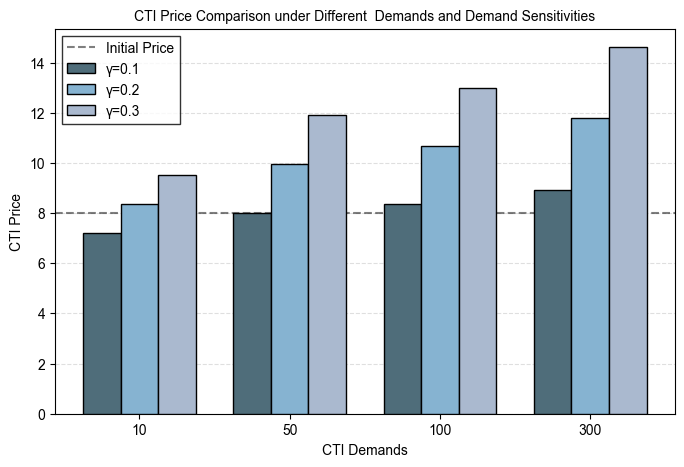

In [10]:


plt.figure(figsize=(8,5))
x = np.arange(len(need_list))
width = 0.25 

init_price = 8

# 先绘制网格
plt.grid(True, axis='y', linestyle='--', alpha=0.4, zorder=0)

colors = ['#4F6D7A', '#86B3D1', '#AAB9CF']  # 使用IEEE风格的配色方案：深灰蓝、浅蓝、淡蓝
#colors = ['#4F6D7A', '#86B3D1', '#FFA07A']  # 使用IEEE风格的配色方案：深灰蓝、浅蓝、浅橙色
patterns = ['/', '\\', 'x']  # 定义不同的斜线填充样式
for i in range(len(gamma_list)):
    prices = [price_list[i] for price_list in cti_price_diff_need_list]
    bar = plt.bar(x + i*width, prices, width, label=f'γ={gamma_list[i]}', alpha=1, color=colors[i],
            edgecolor='black', linewidth=1, zorder=3)
    # 为每个柱子添加斜线填充
    # for patch in bar.patches:
    #     patch.set_hatch(patterns[i])

# 添加初始价格的水平虚线
plt.axhline(y=init_price, color='black', linestyle='--', label='Initial Price',alpha=0.5)

plt.xlabel('CTI Demands', fontname='Arial', fontsize=10)
plt.ylabel('CTI Price', fontname='Arial', fontsize=10)
plt.title('CTI Price Comparison under Different  Demands and Demand Sensitivities', 
         fontname='Arial', fontsize=10)
plt.xticks(x + width, need_list, fontname='Arial', fontsize=10)
plt.legend(edgecolor='black', fancybox=False, prop={'family':'Arial', 'size':10})
plt.show()


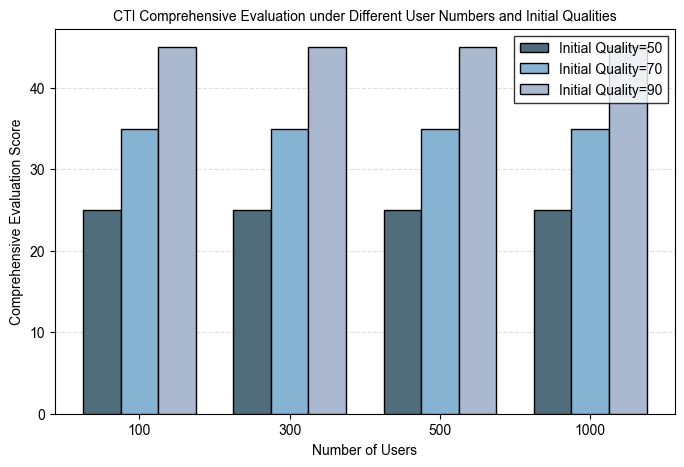

In [62]:
# 绘图部分保持不变
plt.figure(figsize=(8,5))
x = np.arange(len(user_N_list))
width = 0.25

plt.grid(True, axis='y', linestyle='--', alpha=0.4, zorder=0)

colors = ['#4F6D7A', '#86B3D1', '#AAB9CF']
patterns = ['/', '\\', 'x']

for i in range(len(init_quality_list)):
    scores = [score_list[i] for score_list in cti_compre_eval_diff_user_num_list]
    bar = plt.bar(x + i*width, scores, width, label=f'Initial Quality={init_quality_list[i]}', 
            alpha=1, color=colors[i], edgecolor='black', linewidth=1, zorder=3)

plt.xlabel('Number of Users', fontname='Arial', fontsize=10)
plt.ylabel('Comprehensive Evaluation Score', fontname='Arial', fontsize=10)
plt.title('CTI Comprehensive Evaluation under Different User Numbers and Initial Qualities',
         fontname='Arial', fontsize=10)
plt.xticks(x + width, user_N_list, fontname='Arial', fontsize=10)
plt.legend(edgecolor='black', fancybox=False, prop={'family':'Arial', 'size':10})
plt.show()